In [1]:
!pip install chart-studio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 2.7 MB/s eta 0:00:00


In [2]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf

#tf.enable_eager_execution()

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import time
import string

import chart_studio.plotly
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
#%plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go

In [3]:
file_path = '/kaggle/input/123456/por.txt'

In [4]:
lines = open(file_path, encoding='UTF-8').read().strip().split('\n')
lines[0:10]

['Go.\tVai.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1196331 (alexmarcelo)',
 'Go.\tVá.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #5464111 (ToinhoAlam)',
 'Hi.\tOi.\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #397074 (brauliobezerra)',
 'Run!\tCorre!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #1197457 (alexmarcelo)',
 'Run!\tCorra!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #1197458 (alexmarcelo)',
 'Run!\tCorram!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #1197503 (alexmarcelo)',
 'Run.\tCorre!\tCC-BY 2.0 (France) Attribution: tatoeba.org #4008918 (JSakuragi) & #1197457 (alexmarcelo)',
 'Run.\tCorra!\tCC-BY 2.0 (France) Attribution: tatoeba.org #4008918 (JSakuragi) & #1197458 (alexmarcelo)',
 'Run.\tCorram!\tCC-BY 2.0 (France) Attribution: tatoeba.org #4008918 (JSakuragi) & #1197503 (alexmarcelo)',
 'Who?\tQuem?\tCC-BY 2.0 (France) Attribution: tatoeba.org #2083

In [5]:
print("total number of records: ",len(lines))

total number of records:  170305


In [6]:
exclude = set(string.punctuation) # Set of all special characters
remove_digits = str.maketrans('', '', string.digits)

In [7]:
def preprocess_eng_sentence(sent):
    '''Function to preprocess English sentence'''
    sent = sent.lower() # lower casing
    sent = re.sub("'", '', sent) # remove the quotation marks if any
    sent = ''.join(ch for ch in sent if ch not in exclude)
    sent = sent.translate(remove_digits) # remove the digits
    sent = sent.strip()
    sent = re.sub(" +", " ", sent) # remove extra spaces
    sent = '<start> ' + sent + ' <end>' # add <start> and <end> tokens
    return sent

In [8]:
def preprocess_port_sentence(sent):
    '''Function to preprocess Portuguese sentence'''
    sent = re.sub("'", '', sent) # remove the quotation marks if any
    sent = ''.join(ch for ch in sent if ch not in exclude)
    #sent = re.sub("[२३०८१५७९४६]", "", sent) # remove the digits
    sent = sent.strip()
    sent = re.sub(" +", " ", sent) # remove extra spaces
    sent = '<start> ' + sent + ' <end>' # add <start> and <end> tokens
    return sent

In [9]:
sent_pairs = []
for line in lines:
    sent_pair = []
    eng = line.rstrip().split('\t')[0]
    port = line.rstrip().split('\t')[1]
    eng = preprocess_eng_sentence(eng)
    sent_pair.append(eng)
    port = preprocess_port_sentence(port)
    sent_pair.append(port)
    sent_pairs.append(sent_pair)
sent_pairs[5000:5010]

[['<start> why not both <end>', '<start> Por que não ambas <end>'],
 ['<start> why not both <end>', '<start> Por que não os dois <end>'],
 ['<start> why not both <end>', '<start> Por que não as duas <end>'],
 ['<start> will tom die <end>', '<start> O Tom vai morrer <end>'],
 ['<start> will he live <end>', '<start> Ele vai viver <end>'],
 ['<start> will it rain <end>', '<start> Vai chover <end>'],
 ['<start> will it rain <end>', '<start> Será que vai chover <end>'],
 ['<start> will it rain <end>', '<start> Será que chove <end>'],
 ['<start> wish me luck <end>', '<start> Desejeme sorte <end>'],
 ['<start> wont you go <end>', '<start> Você não vai <end>']]

In [10]:
class LanguageIndex():
    def __init__(self, lang):
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()

        self.create_index()

    def create_index(self):
        for phrase in self.lang:
            self.vocab.update(phrase.split(' '))

        self.vocab = sorted(self.vocab)

        self.word2idx['<pad>'] = 0
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1

        for word, index in self.word2idx.items():
            self.idx2word[index] = word

In [11]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [12]:
def load_dataset(pairs, num_examples):
    # pairs => already created cleaned input, output pairs

    # index language using the class defined above
    inp_lang = LanguageIndex(en for en, ma in pairs)
    targ_lang = LanguageIndex(ma for en, ma in pairs)

    # Vectorize the input and target languages

    # English sentences
    input_tensor = [[inp_lang.word2idx[s] for s in en.split(' ')] for en, ma in pairs]

    # Portuguese sentences
    target_tensor = [[targ_lang.word2idx[s] for s in ma.split(' ')] for en, ma in pairs]

    # Calculate max_length of input and output tensor
    # Here, we'll set those to the longest sentence in the dataset
    max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)

    # Padding the input and output tensor to the maximum length
    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor,
                                                                 maxlen=max_length_inp,
                                                                 padding='post')

    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor,
                                                                  maxlen=max_length_tar,
                                                                  padding='post')

    return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar

In [13]:
input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_targ = load_dataset(sent_pairs, len(lines))

In [14]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.1, random_state = 101)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(153274, 153274, 17031, 17031)

In [15]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 128
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word2idx)
vocab_tar_size = len(targ_lang.word2idx)

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val))
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [16]:
def lstm(units):
    return tf.keras.layers.LSTM(units,
                                return_sequences=True,
                                return_state=True,
                                recurrent_activation='sigmoid',
                                recurrent_initializer='glorot_uniform')


In [17]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = lstm(self.enc_units)  # Replace GRU with LSTM

    def call(self, x, hidden, cell):
        x = self.embedding(x)
        output, state_h, state_c = self.lstm(x, initial_state=[hidden, cell])  # LSTM returns (output, hidden, cell)
        return output, state_h, state_c  # Return both hidden and cell states

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units)), tf.zeros((self.batch_sz, self.enc_units))  # Return both hidden & cell

In [18]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(self.dec_units, return_sequences=True, return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

    def call(self, x, hidden, cell):
        # Embedding
        x = self.embedding(x)

        # Passing through LSTM
        output, state_h, state_c = self.lstm(x, initial_state=[hidden, cell])

        # Fully connected layer
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)

        return x, state_h, state_c

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units)), tf.zeros((self.batch_sz, self.dec_units))

In [19]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

In [20]:
optimizer = tf.optimizers.Adam()

def loss_function(real, pred):
    mask = 1 - np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
    return tf.reduce_mean(loss_)

In [21]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [22]:
import numpy as np
import matplotlib.pyplot as plt

EPOCHS = 5
train_loss_history = []
val_loss_history = []

for epoch in range(EPOCHS):
    start = time.time()
    
    # Training
    hidden, cell = encoder.initialize_hidden_state()
    total_train_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0
        with tf.GradientTape() as tape:
            enc_output, enc_hidden, enc_cell = encoder(inp, hidden, cell)

            dec_hidden = enc_hidden
            dec_cell = enc_cell

            dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)

            # Teacher forcing
            for t in range(1, targ.shape[1]):
                predictions, dec_hidden, dec_cell = decoder(dec_input, dec_hidden, dec_cell)
                loss += loss_function(targ[:, t], predictions)
                dec_input = tf.expand_dims(targ[:, t], 1)  # Teacher forcing

        batch_loss = loss / int(targ.shape[1])
        total_train_loss += batch_loss

        variables = encoder.variables + decoder.variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))

        if batch % 100 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Train Loss {batch_loss.numpy():.4f}')

    avg_train_loss = total_train_loss / N_BATCH
    train_loss_history.append(avg_train_loss.numpy())

    # Validation
    total_val_loss = 0
    hidden, cell = encoder.initialize_hidden_state()

    for (batch, (inp, targ)) in enumerate(val_dataset): 
        enc_output, enc_hidden, enc_cell = encoder(inp, hidden, cell)

        dec_hidden = enc_hidden
        dec_cell = enc_cell
        dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)

        loss = 0
        for t in range(1, targ.shape[1]):
            predictions, dec_hidden, dec_cell = decoder(dec_input, dec_hidden, dec_cell)
            loss += loss_function(targ[:, t], predictions)
            dec_input = tf.expand_dims(targ[:, t], 1)

        batch_val_loss = loss / int(targ.shape[1])
        total_val_loss += batch_val_loss

    avg_val_loss = total_val_loss / N_BATCH
    val_loss_history.append(avg_val_loss.numpy())

    checkpoint.save(file_prefix=checkpoint_prefix)

    print(f'Epoch {epoch + 1} Train Loss {avg_train_loss:.4f}, Val Loss {avg_val_loss:.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec\n')

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning:

Gradients do not exist for variables ['seed_generator_state', 'seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?



Epoch 1 Batch 0 Train Loss 2.0021
Epoch 1 Batch 100 Train Loss 1.0927
Epoch 1 Batch 200 Train Loss 1.0264
Epoch 1 Batch 300 Train Loss 0.9231
Epoch 1 Batch 400 Train Loss 0.9425
Epoch 1 Batch 500 Train Loss 0.9129
Epoch 1 Batch 600 Train Loss 0.8542
Epoch 1 Batch 700 Train Loss 0.7776
Epoch 1 Batch 800 Train Loss 0.7681
Epoch 1 Batch 900 Train Loss 0.7532
Epoch 1 Batch 1000 Train Loss 0.6852
Epoch 1 Batch 1100 Train Loss 0.7587
Epoch 1 Train Loss 0.8913, Val Loss 0.0796
Time taken for 1 epoch 1077.56 sec

Epoch 2 Batch 0 Train Loss 0.6754
Epoch 2 Batch 100 Train Loss 0.6484
Epoch 2 Batch 200 Train Loss 0.6121
Epoch 2 Batch 300 Train Loss 0.6559
Epoch 2 Batch 400 Train Loss 0.6110
Epoch 2 Batch 500 Train Loss 0.6044
Epoch 2 Batch 600 Train Loss 0.6278
Epoch 2 Batch 700 Train Loss 0.6385
Epoch 2 Batch 800 Train Loss 0.6152
Epoch 2 Batch 900 Train Loss 0.6034
Epoch 2 Batch 1000 Train Loss 0.5543
Epoch 2 Batch 1100 Train Loss 0.4861
Epoch 2 Train Loss 0.5963, Val Loss 0.0587
Time taken for

In [23]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [24]:
def evaluate(inputs, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    sentence = ''

    for i in inputs[0]:
        if i == 0:
            break
        sentence += inp_lang.idx2word[i] + ' '

    sentence = sentence.strip()

    inputs = tf.convert_to_tensor(inputs)

    result = ''

    # Initialize hidden and cell state for LSTM
    hidden = tf.zeros((1, units))
    cell = tf.zeros((1, units))

    enc_out, enc_hidden, enc_cell = encoder(inputs, hidden, cell)

    dec_hidden = enc_hidden
    dec_cell = enc_cell
    dec_input = tf.expand_dims([targ_lang.word2idx['<start>']], 0)

    for t in range(max_length_targ):
        # Call decoder without attention
        predictions, dec_hidden, dec_cell = decoder(dec_input, dec_hidden, dec_cell)

        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_lang.idx2word[predicted_id] + ' '

        if targ_lang.idx2word[predicted_id] == '<end>':
            return result.strip(), sentence  # No more attention plot

        # Feeding the predicted ID back into the decoder
        dec_input = tf.expand_dims([predicted_id], 0)

    return result.strip(), sentence  # No more attention plot

In [25]:
def calculate_accuracy(encoder, decoder, input_tensor_test, target_tensor_test, inp_lang, targ_lang, max_length_inp, max_length_targ):
    correct_words = 0
    total_words = 0

    for i in range(len(input_tensor_test)):
        input_sentence = np.expand_dims(input_tensor_test[i], 0)
        actual_output = target_tensor_test[i]

        # Updated function call without attention
        predicted_sentence, _ = evaluate(input_sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

        predicted_words = predicted_sentence.split()
        actual_words = [targ_lang.idx2word[word] for word in actual_output if word != 0]

        # Compare words
        for j in range(min(len(predicted_words), len(actual_words))):
            if predicted_words[j] == actual_words[j]:
                correct_words += 1
        total_words += len(actual_words)

    accuracy = (correct_words / total_words) * 100
    return accuracy

# Evaluate the model on the test dataset
accuracy = calculate_accuracy(encoder, decoder, input_tensor_val, target_tensor_val, inp_lang, targ_lang, max_length_inp, max_length_targ)
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 6.99%


In [26]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def calculate_bleu(encoder, decoder, input_tensor_test, target_tensor_test, inp_lang, targ_lang, max_length_inp, max_length_targ):
    total_bleu_score = 0
    num_samples = len(input_tensor_test)
    smooth_fn = SmoothingFunction().method1  # Apply smoothing

    for i in range(num_samples):
        input_sentence = np.expand_dims(input_tensor_test[i], 0)
        actual_output = target_tensor_test[i]

        # Updated function call without attention
        predicted_sentence, _ = evaluate(input_sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

        predicted_words = predicted_sentence.split()
        actual_words = [targ_lang.idx2word[word] for word in actual_output if word != 0]

        # Compute BLEU score with smoothing
        bleu_score = sentence_bleu([actual_words], predicted_words, smoothing_function=smooth_fn)
        total_bleu_score += bleu_score

    # Average BLEU score over all samples
    avg_bleu_score = (total_bleu_score / num_samples) * 100  # Convert to percentage
    return avg_bleu_score

# Compute BLEU score on validation dataset
bleu_score = calculate_bleu(encoder, decoder, input_tensor_val, target_tensor_val, inp_lang, targ_lang, max_length_inp, max_length_targ)
print(f"Test BLEU Score: {bleu_score:.2f}%")

Test BLEU Score: 27.06%


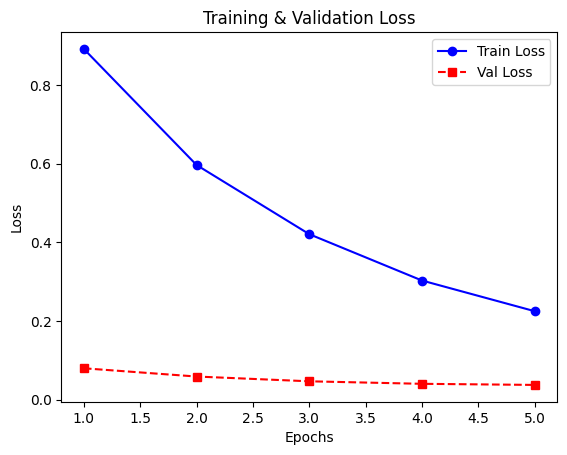

In [27]:
# Plot Training & Validation Loss
plt.plot(range(1, EPOCHS + 1), train_loss_history, marker='o', linestyle='-', color='b', label='Train Loss')
plt.plot(range(1, EPOCHS + 1), val_loss_history, marker='s', linestyle='--', color='r', label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

In [30]:
import numpy as np

def predict_random_val_sentence():
    actual_sent = ''
    k = np.random.randint(len(input_tensor_val))
    random_input = input_tensor_val[k]
    random_output = target_tensor_val[k]

    random_input = np.expand_dims(random_input, 0)
    result, sentence = evaluate(random_input, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

    # Clean up predicted and input sentences
    result = result.replace("<start>", "").replace("<end>", "").strip()
    sentence = sentence.replace("<start>", "").replace("<end>", "").strip()

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))

    for i in random_output:
        if i in [0, targ_lang.word2idx['<start>'], targ_lang.word2idx['<end>']]:
            continue
        actual_sent += targ_lang.idx2word[i] + ' '

    actual_sent = actual_sent.strip()
    print('Actual translation: {}'.format(actual_sent))


In [33]:
predict_random_val_sentence()

Input: hey thats not fair
Predicted translation: Ei não é justo
Actual translation: Ei isso não é justo


In [35]:
import random
import numpy as np
from tabulate import tabulate

def tabulate_predictions(encoder, decoder, input_tensor_test, target_tensor_test, inp_lang, targ_lang, max_length_inp, max_length_targ):
    num_samples = 10  # Hardcoded to select exactly 10 samples
    indices = random.sample(range(len(input_tensor_test)), num_samples)  # Select 10 random indices

    data = []
    for i in indices:
        input_sentence = np.expand_dims(input_tensor_test[i], 0)
        actual_output = target_tensor_test[i]

        predicted_sentence, _ = evaluate(input_sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
        
        # Remove <start> and <end> from predicted sentence
        predicted_sentence = predicted_sentence.replace("<start>", "").replace("<end>", "").strip()

        # Convert actual sentence from tokenized format to words
        actual_sentence = " ".join([
            targ_lang.idx2word[word] for word in actual_output 
            if word not in [0, targ_lang.word2idx['<start>'], targ_lang.word2idx['<end>']]
        ])

        # Convert input sentence to words (assuming input is English)
        english_sentence = " ".join([
            inp_lang.idx2word[word] for word in input_tensor_test[i] 
            if word not in [0, inp_lang.word2idx['<start>'], inp_lang.word2idx['<end>']]
        ])

        data.append([english_sentence, actual_sentence, predicted_sentence])

    # Print formatted table
    print(tabulate(data, headers=["English", "Actual Translation", "Predicted Translation"], tablefmt="fancy_grid", maxcolwidths=[30, 30, 30]))

# Call the function
tabulate_predictions(encoder, decoder, input_tensor_val, target_tensor_val, inp_lang, targ_lang, max_length_inp, max_length_targ)

╒═══════════════════════════════╤════════════════════════════════╤════════════════════════════════╕
│ English                       │ Actual Translation             │ Predicted Translation          │
╞═══════════════════════════════╪════════════════════════════════╪════════════════════════════════╡
│ tom is quite cooperative      │ Tom é bastante cooperativo     │ Tom é bastante cooperativo     │
├───────────────────────────────┼────────────────────────────────┼────────────────────────────────┤
│ ill wait for you until        │ Esperarei por você até as duas │ Vou esperar até você           │
│                               │ e meia                         │                                │
├───────────────────────────────┼────────────────────────────────┼────────────────────────────────┤
│ tom isnt used to city life    │ O Tom não está acostumado à    │ Tom não está acostumado a vida │
│                               │ vida urbana                    │ urbana                         │
